# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


In [3]:
# !pip install fluidsynth
# !pip install --upgrade pyfluidsynth
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [8]:
# set datapath, data source: https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
data_dir = pathlib.Path('data/maestro-v2.0.0')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Preprocess

midi file is different format from typical audio(mp3,wav) it a record of pitch/velocity/duration of the note instead of actual sound recording

 prepare midi_to_note function, this is to extract midi file into note
which is contain 
- pitch - the key of the note range from 0-127 starting from C-1 (C in lowest octave)
from the example file
    - 55 is G3
    - 81 is A#5 (A sharp)
    - 62 is D4 etc
- start,end - when do note start and end in the sequence which use to calculate duration
- step - different between start of itself and start of the note before them (this is for knowning space between each note)

In [20]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

sample_file = 'example.midi'
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,0.000000,0.079545,0.000000,0.079545
1,31,0.009091,0.075000,0.009091,0.065909
2,44,0.111364,0.184091,0.102273,0.072727
3,32,0.113636,0.186364,0.002273,0.072727
4,46,0.175000,0.270455,0.061364,0.095455


# Visualize note seqeunce

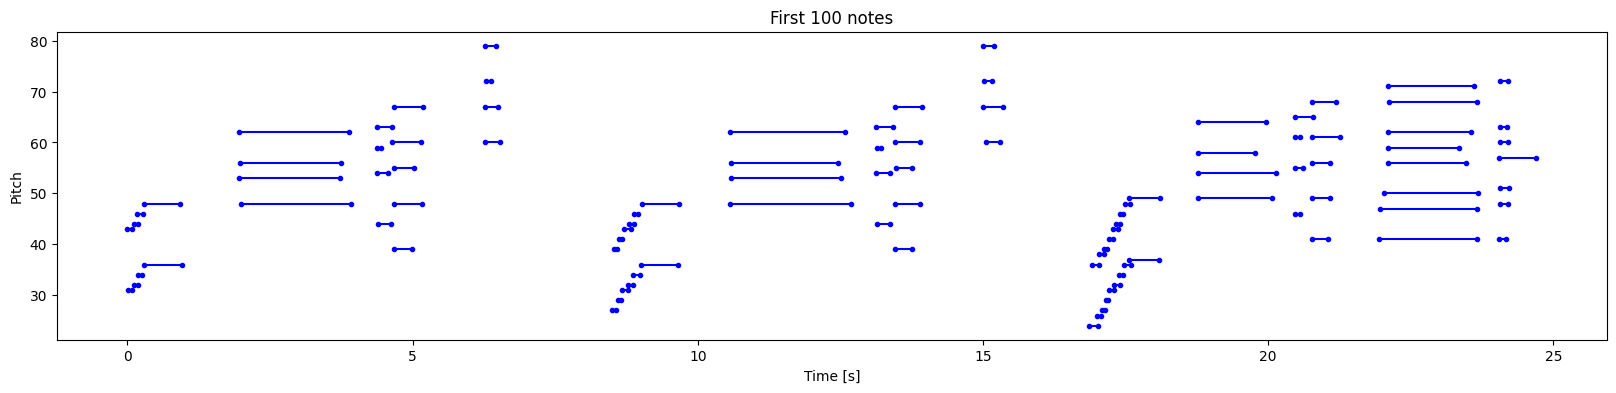

In [22]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

#first 300 note
plot_piano_roll(raw_notes, count=100)    

## Function for playing Midi file
midi file is different format from typical audio(mp3,wav) it a record of pitch/velocity/duration of the note instead of actual sound recording

In [24]:
import pygame
import time

def play_midi(file_path):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()
    
    # Wait a bit to ensure playback has started
    time.sleep(2)
    
    print("Press 'q' to quit")
    while pygame.mixer.music.get_busy():
        # Check for keyboard input to stop playback
        if input("Press 'q' to quit: ").lower() == 'q':
            pygame.mixer.music.stop()
            break

example_file = 'example.midi'
play_midi(example_file)

Press 'q' to quit


Press 'q' to quit:  q


## Create training dataset

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key].values for key in key_order], axis=1)

# Convert to PyTorch tensors
train_notes = torch.tensor(train_notes, dtype=torch.float32)

class NotesDataset(Dataset):
    def __init__(self, notes, seq_length):
        self.notes = notes
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.notes) - self.seq_length
    
    def __getitem__(self, idx):
        idx = idx.item() if torch.is_tensor(idx) else idx
        return {
            'sequence': self.notes[idx:idx+self.seq_length],
            'target': self.notes[idx+self.seq_length]
        }

def collate_fn(batch):
    sequences = [item['sequence'] for item in batch]
    targets = [item['target'] for item in batch]
    return {
        'sequences': torch.stack(sequences),
        'targets': torch.stack(targets)
    }

seq_length = 25
notes_ds = NotesDataset(train_notes, seq_length)
train_loader = DataLoader(notes_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Example usage
for batch in train_loader:
    seq_batch, target_batch = batch['sequences'], batch['targets']
    print('Sequence batch shape:', seq_batch.shape)
    print('Target batch shape:', target_batch.shape)
    break  # Stop after the first batch for demonstration


Number of notes parsed: 37241
Sequence batch shape: torch.Size([64, 25, 3])
Target batch shape: torch.Size([64, 3])


---
### Questions
Answer the following questions in detail.

1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.
2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?
3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?
4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?
5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.
6. Explain the role of the hidden state in an RNN. How is it updated during the training process?
7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?
8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.
9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?
10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.